In [10]:
%matplotlib inline 

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from assemble import DataStream, DataDescribe, Category, DataCleaner
import warnings
import json
import pickle

from sklearn.feature_selection import RFE
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import RandomizedLasso
from sklearn.preprocessing import MinMaxScaler

plt.style.use('ggplot')
warnings.filterwarnings('ignore')

In [2]:
X_train, X_test, y  = DataStream.read_for_learn("data.json", "2-20Submit-Polynomal")

In [3]:
print(X_train.shape)
print(X_test.shape)
print(y.shape)

(1456, 114)
(1459, 114)
(1456,)


# A dictonary to store all ranks

In [20]:
ranks={}
names=X_train.columns
def rank_to_dict(ranks, names, order=1):
    minmax = MinMaxScaler()
    ranks = minmax.fit_transform(order*np.array([ranks]).T).T[0]
    ranks = map(lambda x: round(x, 2), ranks)
    return dict(zip(names, ranks ))

# Randomlized Lasso
http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RandomizedLasso.html
http://blog.datadive.net/selecting-good-features-part-iv-stability-selection-rfe-and-everything-side-by-side/

In [4]:
rlasso = RandomizedLasso(alpha=2e-4, max_iter=50000,random_state=1,n_resampling=500)
rlasso.fit(X_train, y.values.ravel())

In [21]:
#print ("Features sorted by their score:")
#rlasso_score = sorted(zip(map(lambda x: round(x, 4), rlasso.scores_), 
#                 names), reverse=True)
ranks["Rand_La"] = rank_to_dict(np.abs(rlasso.scores_), names)

# Recursive elimination

In [12]:
lasso = Lasso(alpha=2e-4, max_iter=50000)
#rank all features, i.e continue the elimination until the last one
rfe = RFE(lasso)
rfe.fit(X_train, y.values.ravel())

RFE(estimator=Lasso(alpha=0.0002, copy_X=True, fit_intercept=True, max_iter=50000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False),
  n_features_to_select=None, step=1, verbose=0)

In [22]:
#print ("Features sorted by their score:")
#rfe_rank = sorted(zip(map(lambda x: round(x, 4), rfe.ranking_), 
#                 names), reverse=True)
#print (rfe_rank)
ranks["Rec_Eli"] = rank_to_dict(np.abs(rfe.ranking_), names)

# Report of feature ranks

In [36]:
r = {}
for name in names:
    r[name] = round(np.mean([ranks[method][name] 
                             for method in ranks.keys()]), 2)

ranks["Mean"] = r

ranks_pd = pd.DataFrame(ranks)
ranks_sort=ranks_pd.sort(["Mean","Rand_La","Rec_Eli"],ascending=[False,False,False])
print(ranks_sort)

                   Mean  Rand_La  Rec_Eli
ExterScore_Sq      0.74     0.49     1.00
Neighborhood_E     0.64     0.50     0.79
KitchenAbvGr       0.52     0.56     0.49
KitchenQual_E      0.52     0.24     0.81
ExterScore_S2      0.52     0.10     0.95
ExterScore_S3      0.52     0.07     0.98
OverallQual        0.51     0.32     0.70
BsmtCond_E         0.51     0.13     0.89
ExterQual_E_Sq     0.51     0.09     0.93
ExterQual_E        0.51     0.06     0.96
LotArea            0.50     1.00     0.00
SaleCondition_E    0.50     1.00     0.00
MSZoning_E         0.50     0.99     0.00
PoolScore          0.49     0.07     0.91
CentralAir_E       0.48     0.97     0.00
Electrical_E       0.48     0.10     0.86
Utilities_E        0.46     0.04     0.88
OverallQual_S2     0.45     0.30     0.60
Neighborhood_E_S3  0.45     0.23     0.67
BsmtFinSF1         0.44     0.89     0.00
TotRmsAbvGrd       0.44     0.07     0.82
3SsnPorch          0.42     0.00     0.84
Functional_E       0.40     0.80  

## select features without any zero ranks

In [108]:
#######################################################
# please change eps to decide which features are used #
#######################################################
eps = 0.01

#ranks_sort = ranks_sort.apply(pd.to_numeric)
rank_names = ranks_sort.columns
#print(ranks_sort)
#featrue_names = list(ranks_sort.index)
#print(feature_names)
index_zero = []
for rankname in rank_names:
    #index_zero = index_zero + list(
    #    set(list( feature_names[i] for i in np.where(ranks_sort[rankname]<eps)[0] )) 
    #    - set(index_zero)) 
    index_zero = index_zero + list(set(np.where(ranks_sort[rankname]<eps)[0]) - set(index_zero)) 

#print((ranks_sort.iloc[[0]].index)[0])
feature_zero = list( (ranks_sort.iloc[[i]].index)[0] for i in index_zero)
#print(feature_zero)

ranks_non_zero = ranks_sort.drop(feature_zero)
feature_non_zero = list(ranks_non_zero.index)
#print(ranks_non_zero)

print ("Features with too low rank:")
print(feature_zero)
print ("Features with sufficient rank:")
print(feature_non_zero)

Features with too low rank:
['Alley_E', 'HouseStyle_E', 'KitchenScore', 'MoSold_E', 'BsmtHalfBath', 'EnclosedPorch', 'MiscVal', 'Fence_E', 'PoolQC_E', '3SsnPorch', 'BedroomAbvGr', 'Condition2_E', 'LotArea', 'SaleCondition_E', 'MSZoning_E', 'CentralAir_E', 'BsmtFinSF1', 'Functional_E', 'BsmtExposure_E', 'OverallScore', 'totalArea', 'totalBedRooms', 'HeatingQC_E', '1stFlrSF', 'MSSubClass_E', 'GrLivArea', 'FireplaceScore', 'YearBuilt', 'YearRemodAdd', 'Condition1_E', 'FlrSF', 'GarageGrade', 'BsmtQual_E_S3', 'GarageFinish_E', 'PavedDrive_E', 'ScreenPorch', 'Foundation_E', 'KitchenQual_E_S3', 'GarageCars_S2', 'Neighborhood_E_S2', 'SaleType_E', 'WoodDeckSF', 'OverallQual_Sq', 'Exterior1st_E', 'GarageScore', 'FireplaceQu_E', 'GarageCars', 'PorchSF', 'OverallCond', 'BsmtFullBath', 'OverallQual_S3', 'Neighborhood_E_Sq', 'Fireplaces', 'LotConfig_E', 'Street_E', 'HalfBath', 'GarageCond_E', 'MasVnrType_E', 'LandContour_E', 'ExterCond_E', 'ExterQual_E_S3', 'YrSold', 'BsmtFinSF2', 'Exterior2nd_E', '

# Prediction to submit

In [4]:
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error

def rmsle(y, y_pred):
     return np.sqrt((( (np.log1p(y_pred*price_scale)- np.log1p(y*price_scale)) )**2).mean())

# scorer = make_scorer(rmsle, False)
scorer = make_scorer(mean_squared_error, False)

def rmse_cv(model, X, y):
     return (cross_val_score(model, X, y, scoring=scorer)).mean()

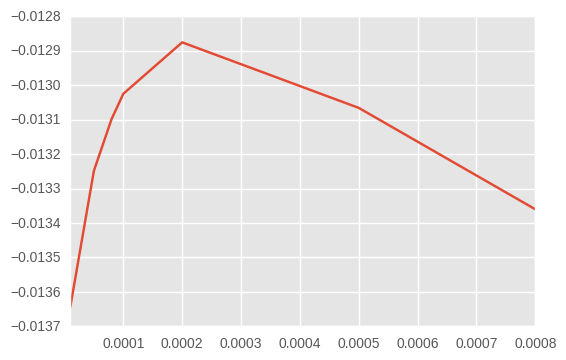

In [5]:
from sklearn.linear_model import Lasso
alphas = [1e-5, 5e-5, 8e-5, 1e-4,2e-4, 5e-4, 8e-4]
cv_lasso = [rmse_cv(Lasso(alpha = alpha, max_iter=50000), X_train, y) for alpha in alphas]
pd.Series(cv_lasso, index = alphas).plot()

In [6]:
model = Lasso(alpha = 8e-4, max_iter =  50000).fit(X_train, y)

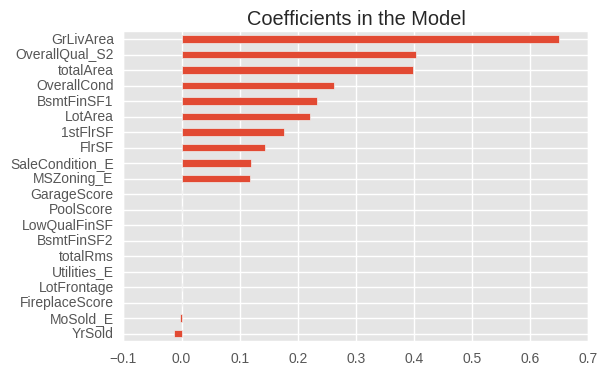

In [7]:
coef = pd.Series(model.coef_, index = X_train.columns).sort_values()
imp_coef = pd.concat([coef.head(10), coef.tail(10)])
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Model")

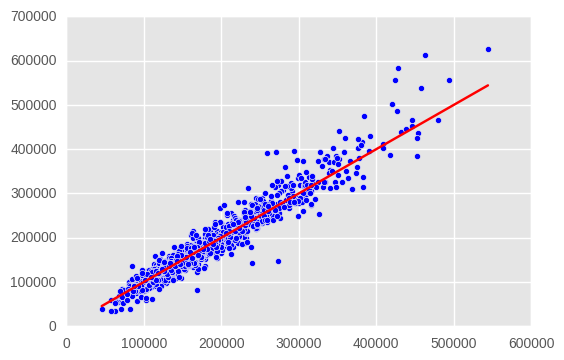

In [8]:
p_pred = np.expm1(model.predict(X_train))
plt.scatter(p_pred, np.expm1(y))
plt.plot([min(p_pred),max(p_pred)], [min(p_pred),max(p_pred)], c="red")